# Compare sourmashconsumr accumulation curves against Nonpareil output metrics

This notebook compares sourmashconsumr accumulation curves against Nonpareil output metrics. These methods are designed to estimate whether a sequencing sample has been sequenced at sufficient depth to capture the full diversity of the sample.

## Notebook setup

In [1]:
setwd("..")

In [2]:
library(Nonpareil)
library(sourmashconsumr)
library(dplyr)
library(tibble)
library(readr)
library(ggplot2)
source("scripts/utils.R")


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [3]:
# use Arcadia brand font if present
if(file.exists("inputs/SuisseIntl-Regular.otf")){
  library(showtext)
  font_add("SuisseIntl-Regular", "inputs/SuisseIntl-Regular.otf")
  showtext::showtext_auto()
  theme_arcadia <- theme_classic() +
    theme(text = element_text(family = "SuisseIntl-Regular"))
} else {
  theme_arcadia <- theme_classic()
}

Loading required package: sysfonts

Loading required package: showtextdb



In [4]:
# adjust plot size rendered inline
options(repr.plot.width = 3, repr.plot.height = 3, repr.plot.res = 300)

## Calculate nonpareil estimates from command line tool \*npo output files

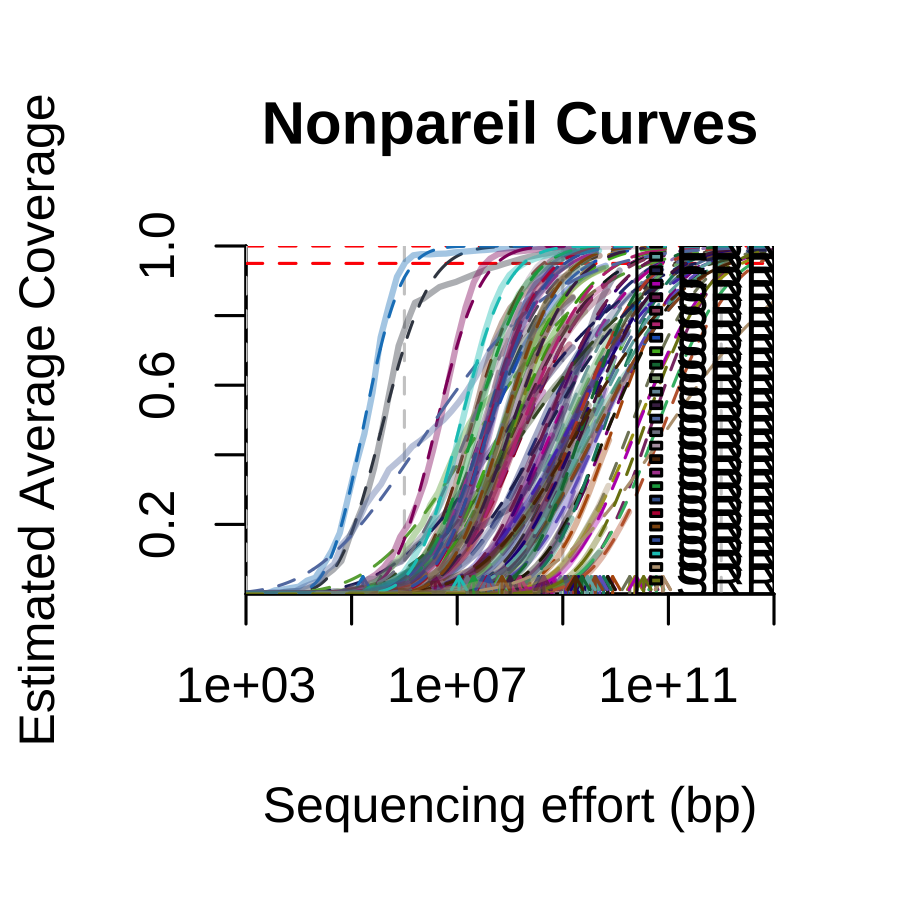

In [5]:
nonpareil <- Nonpareil.set(Sys.glob("outputs/nonpareil/*npo"))

## Estimate mean slope from sourmashconsumr accumulation curves

In [6]:
rarefaction_df <- Sys.glob("outputs/sourmashconsumr_rarefaction/*fastp_100k_rarefaction.tsv") %>%
  purrr::map_dfr(read_tsv, show_col_types = F)

In [7]:
# calculate the average slope and minimum non-zero slope as an estimate for saturation
slope_df <- data.frame()
for(accession_i in unique(rarefaction_df$name)){
  rarefaction_accession_i <- rarefaction_df %>% 
    filter(name == accession_i)
  run_i <- diff(rarefaction_accession_i$num_kmers_sampled)
  rise_i <- diff(rarefaction_accession_i$num_kmers_observed)
  slope_i <- rise_i/run_i
  mean_slope_i <- mean(slope_i)
  min_nonzero_slope_i <- min(slope_i[slope_i != 0]) # filter out zero values and then calculate the minimum slope observed
  slope_df_i <- data.frame(accession = accession_i,
                           mean_slope = mean_slope_i,
                           min_nonzero_slope = min_nonzero_slope_i)
  slope_df <- bind_rows(slope_df, slope_df_i)
}

In [8]:
head(slope_df)

,accession,mean_slope,min_nonzero_slope
,<chr>,<dbl>,<dbl>
1,ERR1104488,0.2049527,5.414759e-06
2,ERR1135432,0.2006324,6.869305e-06
3,ERR1201173,0.1470484,8.615900e-06
4,ERR1201178,0.2333366,2.207769e-05
5,ERR1223843,0.2022651,4.505873e-06
6,ERR1303295,0.3338921,4.355898e-06


## Compare to sourmashconsumr to pipeline nonpareil estimates

In [9]:
pipeline_estimates <- summary(nonpareil) %>%
  as.data.frame() %>%
  rownames_to_column("accession") %>%
  left_join(slope_df, by = "accession")

In [10]:
pipeline_estimates <- pipeline_estimates %>%
  tidyr::drop_na()

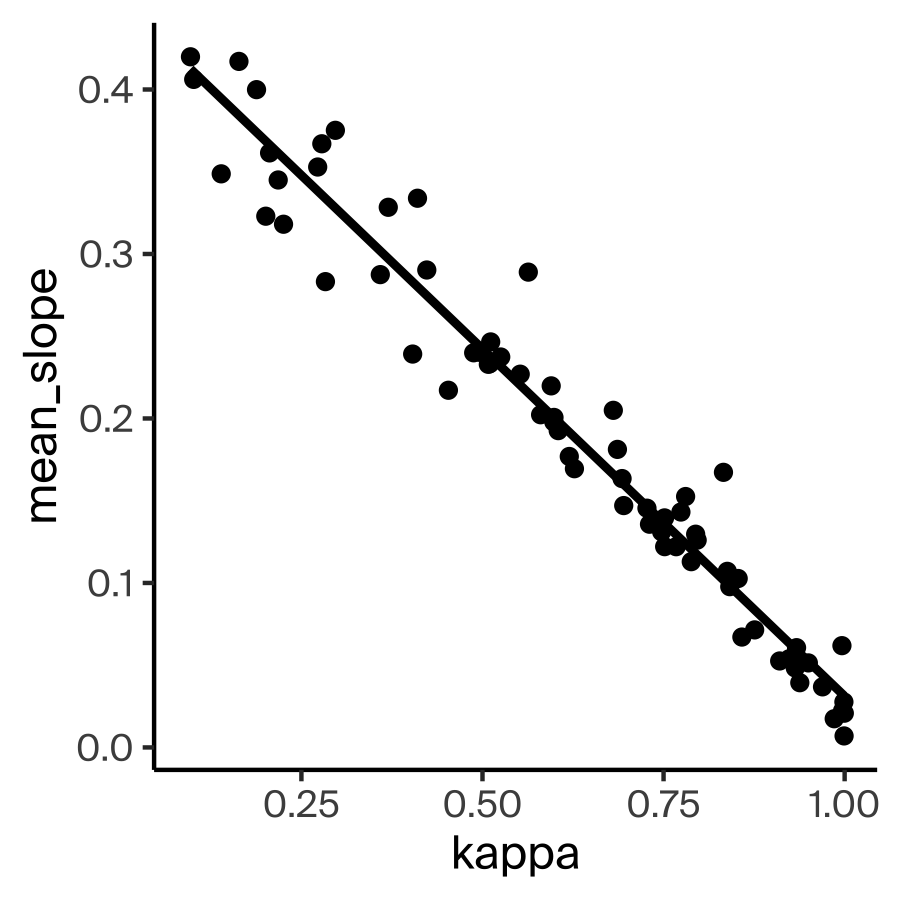

In [11]:
ggplot(pipeline_estimates, aes(x = kappa, y = mean_slope)) +
  geom_point() +
  stat_smooth_func(geom = 'text', method = 'lm', hjust = -8, parse = T) +
  geom_smooth(method = "lm", se=FALSE, color="black", formula = y ~ x) +
  theme_arcadia

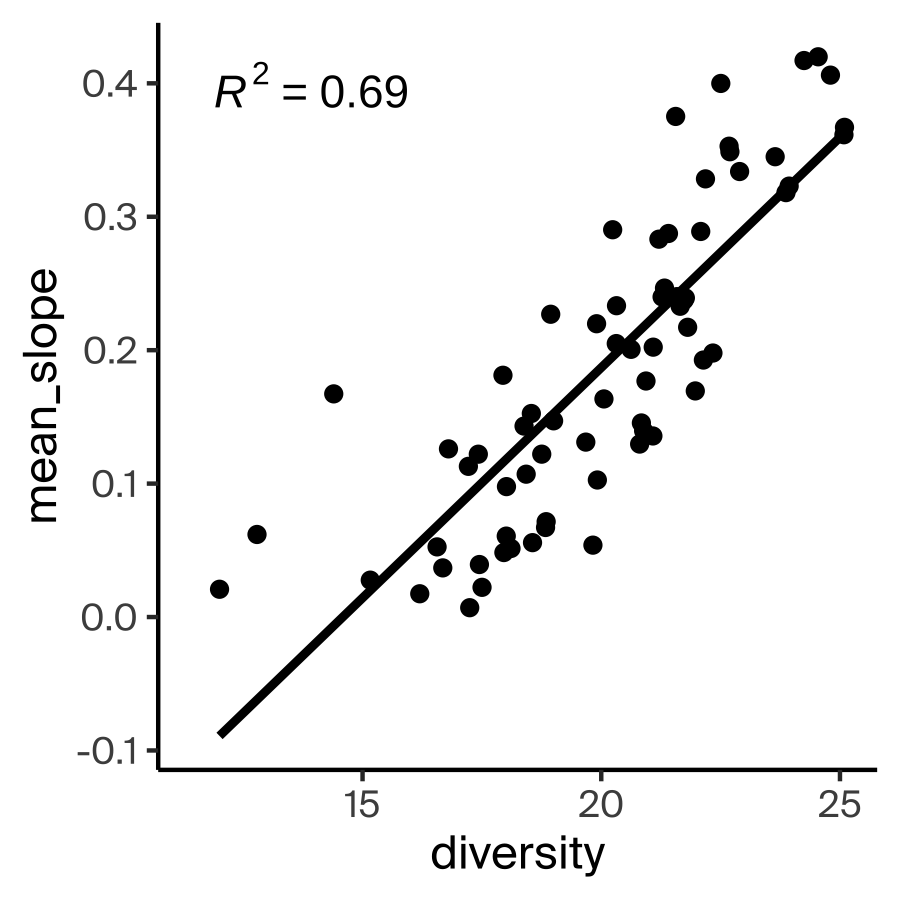

In [12]:
ggplot(pipeline_estimates, aes(x = diversity, y = mean_slope)) +
  geom_point() + 
  stat_smooth_func(geom = 'text', method = 'lm', hjust = 0, parse = T) +
  geom_smooth(method = "lm", se=FALSE, color="black", formula = y ~ x) +
  theme_arcadia

In [13]:
cor(pipeline_estimates[ , -1])

,kappa,C,LR,modelR,LRstar,diversity,mean_slope,min_nonzero_slope
kappa,1.00000000,0.99976585,0.13279090,-0.021382969,-0.178352547,-0.85771112,-0.977452744,-0.540286470
C,0.99976585,1.00000000,0.13265837,-0.020120358,-0.178485009,-0.85514960,-0.976468902,-0.545622972
LR,0.13279090,0.13265837,1.00000000,-0.033511640,0.040767153,0.22005602,-0.151262374,-0.366634102
modelR,-0.02138297,-0.02012036,-0.03351164,1.000000000,-0.749081395,-0.04289298,-0.006226226,0.038673419
LRstar,-0.17835255,-0.17848501,0.04076715,-0.749081395,1.000000000,0.24076021,0.206174230,-0.007572971
diversity,-0.85771112,-0.85514960,0.22005602,-0.042892983,0.240760214,1.00000000,0.830552000,0.215537210
mean_slope,-0.97745274,-0.97646890,-0.15126237,-0.006226226,0.206174230,0.83055200,1.000000000,0.521452547
min_nonzero_slope,-0.54028647,-0.54562297,-0.36663410,0.038673419,-0.007572971,0.21553721,0.521452547,1.000000000


## Join with nonpareil paper fig2 data and compare
mSystems_00039_18 is a subset of the DOI for the [nonpareil 3 paper](https://journals.asm.org/doi/10.1128/mSystems.00039-18) (DOI: 10.1128/mSystems.00039-18). The following estimates were posted to [a gist](https://gist.github.com/lmrodriguezr/c74684c275aa3e4db57a78e94c4fb7c0) by the first author of the nonpareil 3 paper. They contain the data produced in figure 2:

<img src="https://journals.asm.org/cms/10.1128/mSystems.00039-18/asset/da2cd7f8-23ba-416c-9427-b985739ca15c/assets/graphic/sys0031822250002.jpeg" width="500" height="500" />

In [14]:
mSystems_00039_18_fig2_samples <- read_tsv("https://gist.githubusercontent.com/lmrodriguezr/c74684c275aa3e4db57a78e94c4fb7c0/raw/e00c673b8c12fcdde5c29f1f05e47841b6795366/metadata-all.tsv", 
                                           show_col_types = F) %>%
 select(name = Name, accession = Sample)
head(mSystems_00039_18_fig2_samples)

name,accession
<chr>,<chr>
Human_Stool,SRR2175645
Human_Anterior_nares,SRR2240256
Human_Posterior_fornix,SRR2175824
Human_Posterior_fornix_B,SRR1952599
Human_Tongue_dorsum,SRR1952591
Human_Supragingival_plaque,SRR1952623


In [15]:
mSystems_00039_18_fig2 <- read_tsv("https://gist.githubusercontent.com/lmrodriguezr/c74684c275aa3e4db57a78e94c4fb7c0/raw/e00c673b8c12fcdde5c29f1f05e47841b6795366/TableS3.tsv", 
                                   show_col_types = F) %>%
  left_join(mSystems_00039_18_fig2_samples, by = c("sample" = "name")) %>%
  right_join(pipeline_estimates, by = c("accession")) %>%
  select(-"NA") %>%
  tidyr::drop_na()
head(mSystems_00039_18_fig2)

biome,sample,h,nd,mg.cov,hc,ssu.cnt,ssu.cov,accession,kappa,C,LR,modelR,LRstar,diversity,mean_slope,min_nonzero_slope
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
animal-host,Broiler_Caecum,6.067635,19.27679,0.6330464,6.402428,10169,0.4847814,ERR1307052,0.55208,0.5809770,424103045,0.9988361,1.965050e+10,18.94123,0.22692611,5.861773e-05
animal-host,Human_Anterior_nares,4.533079,21.17709,0.6174263,4.699889,4022,0.6234177,SRR2240256,0.83270,0.8458961,234762354,0.9945915,1.083588e+10,14.39666,0.16725352,7.296959e-05
animal-host,Human_Buccal_mucosa,4.493421,20.62078,0.6691931,4.576688,86721,0.5611511,SRR2241209,0.91032,0.9176953,1274828916,0.9993203,1.514192e+09,16.56088,0.05257443,1.978889e-06
animal-host,Human_Medieval_Skeleton,7.001415,21.75052,0.4006209,7.248901,4059,0.3471252,ERR472949,0.36991,0.4028915,2489964753,0.9955898,1.291990e+12,22.18293,0.32838972,1.378119e-05
animal-host,Human_Rheumatoid_Gut,5.729198,19.91891,0.9386193,5.799572,267972,0.6461459,ERR589719,0.93051,0.9362833,5803788756,0.9996135,3.798416e+09,18.56021,0.05575357,3.479036e-07
animal-host,Human_Skin,4.789348,21.04367,0.8135777,4.995904,6727,0.7057793,ERR981247,0.92339,0.9297323,11915412768,0.9748481,3.596446e+11,19.82532,0.05388092,5.035326e-08


In [16]:
# create a correlation matrix to quickly assess similarity among all metrics
tmp <- mSystems_00039_18_fig2 %>%
  select(-biome, -sample, -accession)
cor(tmp)

,h,nd,mg.cov,hc,ssu.cnt,ssu.cov,kappa,C,LR,modelR,LRstar,diversity,mean_slope,min_nonzero_slope
h,1.000000000,0.77564999,-0.74028575,0.9976393013,-0.186192502,-0.68767395,-0.78324270,-0.78583848,0.09666288,0.0031806615,0.20225914,0.7822464,0.7597438272,0.25253733
nd,0.775649985,1.00000000,-0.82715314,0.7772780518,-0.336931049,-0.40769480,-0.82114140,-0.81928368,0.29809479,-0.0378002894,0.18063685,0.9284286,0.8142137427,0.24404366
mg.cov,-0.740285750,-0.82715314,1.00000000,-0.7476093542,0.214237722,0.60167773,0.90108807,0.90289543,-0.13921553,0.0204471161,-0.21374196,-0.8434881,-0.8864469264,-0.48370558
hc,0.997639301,0.77727805,-0.74760935,1.0000000000,-0.203638725,-0.69108934,-0.79873547,-0.80057888,0.07683891,0.0006832115,0.20433190,0.7904102,0.7746196119,0.26041095
ssu.cnt,-0.186192502,-0.33693105,0.21423772,-0.2036387248,1.000000000,0.19551215,0.19600177,0.19211024,-0.04123457,0.0021677034,-0.01838991,-0.3628114,-0.2061569502,-0.07476197
ssu.cov,-0.687673949,-0.40769480,0.60167773,-0.6910893441,0.195512152,1.00000000,0.66660068,0.67352731,0.28618655,-0.1649455040,0.02056919,-0.4381941,-0.6268755328,-0.45942476
kappa,-0.783242696,-0.82114140,0.90108807,-0.7987354689,0.196001772,0.66660068,1.00000000,0.99976578,0.07621830,-0.0267532787,-0.17810653,-0.8556255,-0.9769434004,-0.53718076
C,-0.785838475,-0.81928368,0.90289543,-0.8005788761,0.192110241,0.67352731,0.99976578,1.00000000,0.07747092,-0.0253498884,-0.17819181,-0.8529294,-0.9760313515,-0.54253805
LR,0.096662880,0.29809479,-0.13921553,0.0768389139,-0.041234566,0.28618655,0.07621830,0.07747092,1.00000000,-0.0477561509,0.05062223,0.2884167,-0.0878629156,-0.36679112
modelR,0.003180661,-0.03780029,0.02044712,0.0006832115,0.002167703,-0.16494550,-0.02675328,-0.02534989,-0.04775615,1.0000000000,-0.74901510,-0.0396042,-0.0006269217,0.04091529


In [17]:
# create a function that an initial ggplot can be piped into to add all of the formatting in one go
lm_plt_layers <- function(init_ggplot) {
    init_ggplot + 
    geom_point(size = 1.5, aes(color = biome)) +
    geom_smooth(method = "lm", se=FALSE, color="black", formula = y ~ x) +
    stat_smooth_func(geom = 'text', method = 'lm', hjust = 0, parse = T, size = 3) +
    theme_classic() +
    scale_color_manual(values = c("#E69F00", "#56B4E9", "#009E73",
                                  "#F0E442", "#0072B2", "#CC79A7"))
    #theme_arcadia
}

In [18]:
# summary(lm(h ~ mean_slope, mSystems_00039_18_fig2))
mean_slope_vs_h <- ggplot(mSystems_00039_18_fig2, aes(x = h, y = mean_slope)) %>%
  lm_plt_layers() +
  labs(x = expression(paste("16s rRNA ", italic("H'"), " (2018)")), y = expression(paste("sourmashconsumr ", bar(italic("slope")))))

In [19]:
#summary(lm(nd ~ mean_slope, mSystems_00039_18_fig2))
mean_slope_vs_nd <- ggplot(mSystems_00039_18_fig2, aes(x = nd, y = mean_slope)) %>%
  lm_plt_layers() +
  labs(x = "Nonpareil diversity (2018)", y = expression(paste("sourmashconsumr ", bar(italic("slope")))))

In [20]:
mean_slope_vs_div <- ggplot(mSystems_00039_18_fig2, aes(x = diversity, y = mean_slope)) %>%
  lm_plt_layers() +
  labs(x = "Nonpareil diversity (calc)", y = expression(paste("sourmashconsumr ", bar(italic("slope")))))

In [21]:
# summary(lm(nd ~ h, mSystems_00039_18_fig2))
nd_vs_h <- ggplot(mSystems_00039_18_fig2, aes(x = h, y = nd)) %>%
  lm_plt_layers() +
  labs(x = expression(paste("16s rRNA ", italic("H'"), " (2018)")), y = "Nonpareil diversity (2018)")

In [22]:
div_vs_h <- ggplot(mSystems_00039_18_fig2, aes(x = h, y = diversity)) %>%
  lm_plt_layers() + 
  labs(x = expression(paste("16s rRNA ", italic("H'"), " (2018)")), y = "Nonpareil diversity (calc)")

In [23]:
div_vs_nd <- ggplot(mSystems_00039_18_fig2, aes(x = nd, y = diversity)) %>%
  lm_plt_layers() + 
  labs(x = "Nonpareil diversity (2018)", y = "Nonpareil diversity (calc)")

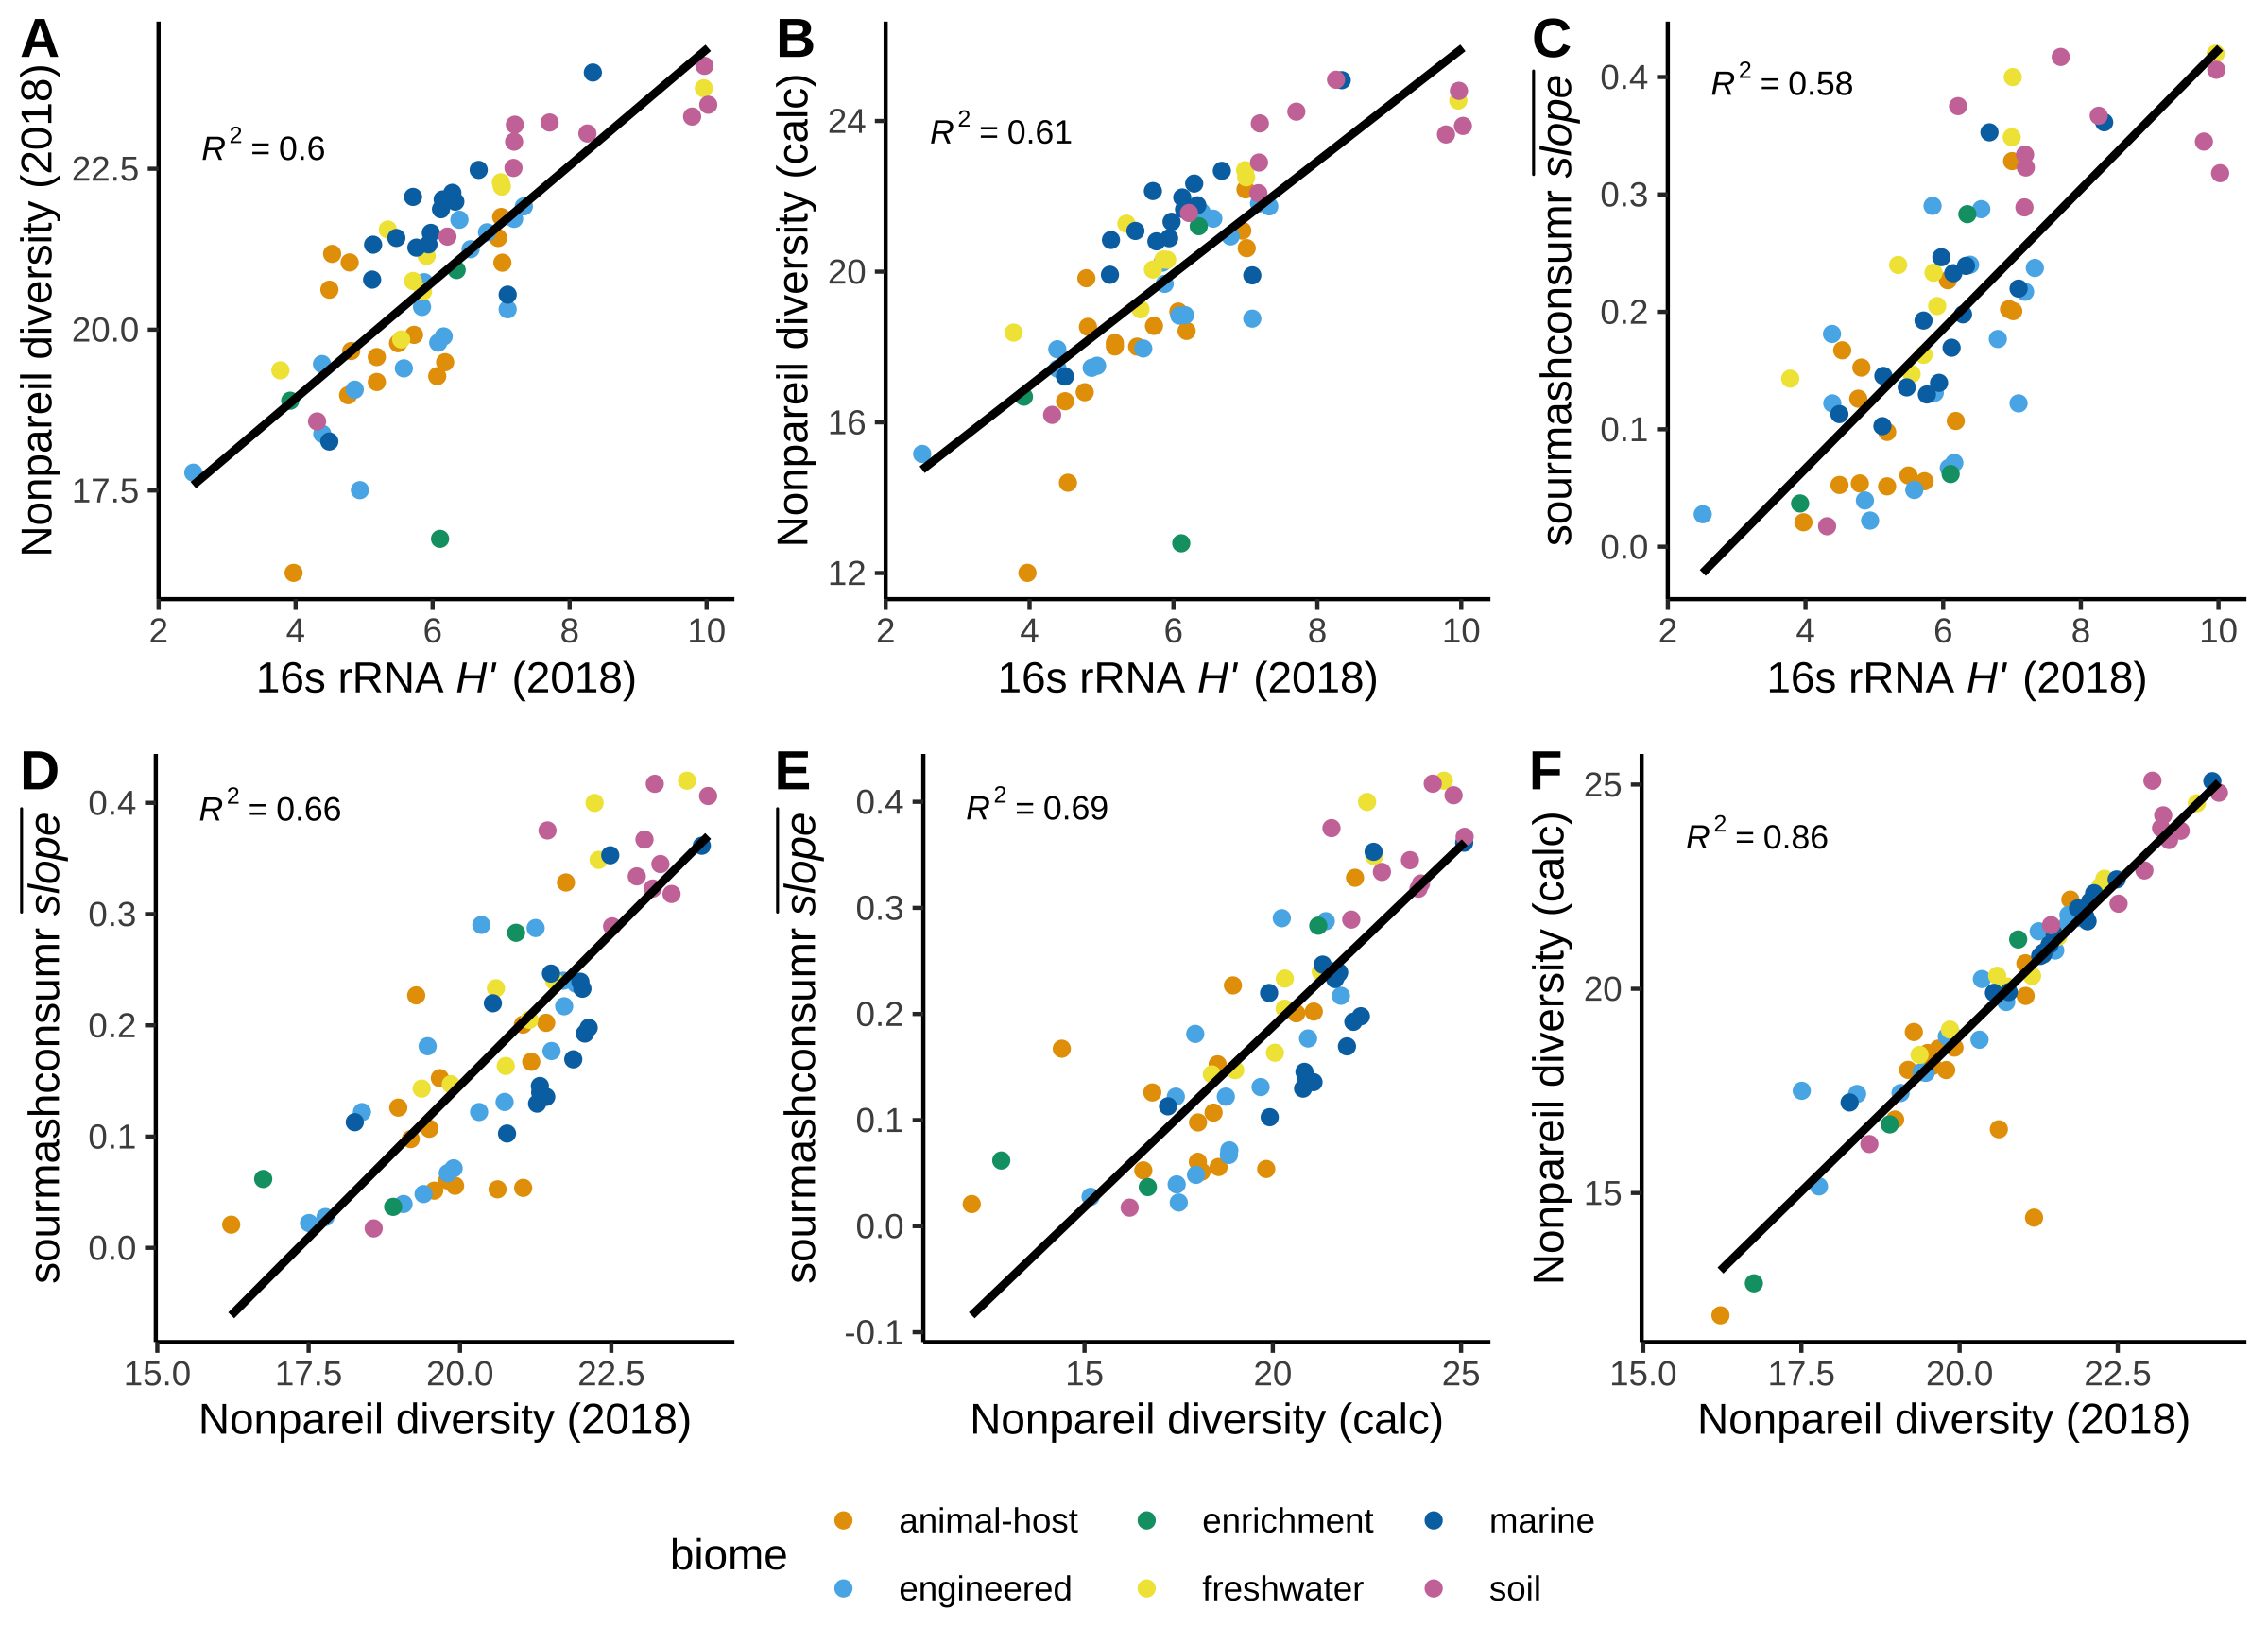

In [24]:
options(repr.plot.width = 8, repr.plot.height = 5.8, repr.plot.res = 300)

ggpubr::ggarrange(nd_vs_h, div_vs_h, mean_slope_vs_h, 
                  mean_slope_vs_nd, mean_slope_vs_div, div_vs_nd,
                  ncol = 3, nrow = 2, legend = "bottom", common.legend = T,
                  labels = c("A", "B", "C", "D", "E", "F"))

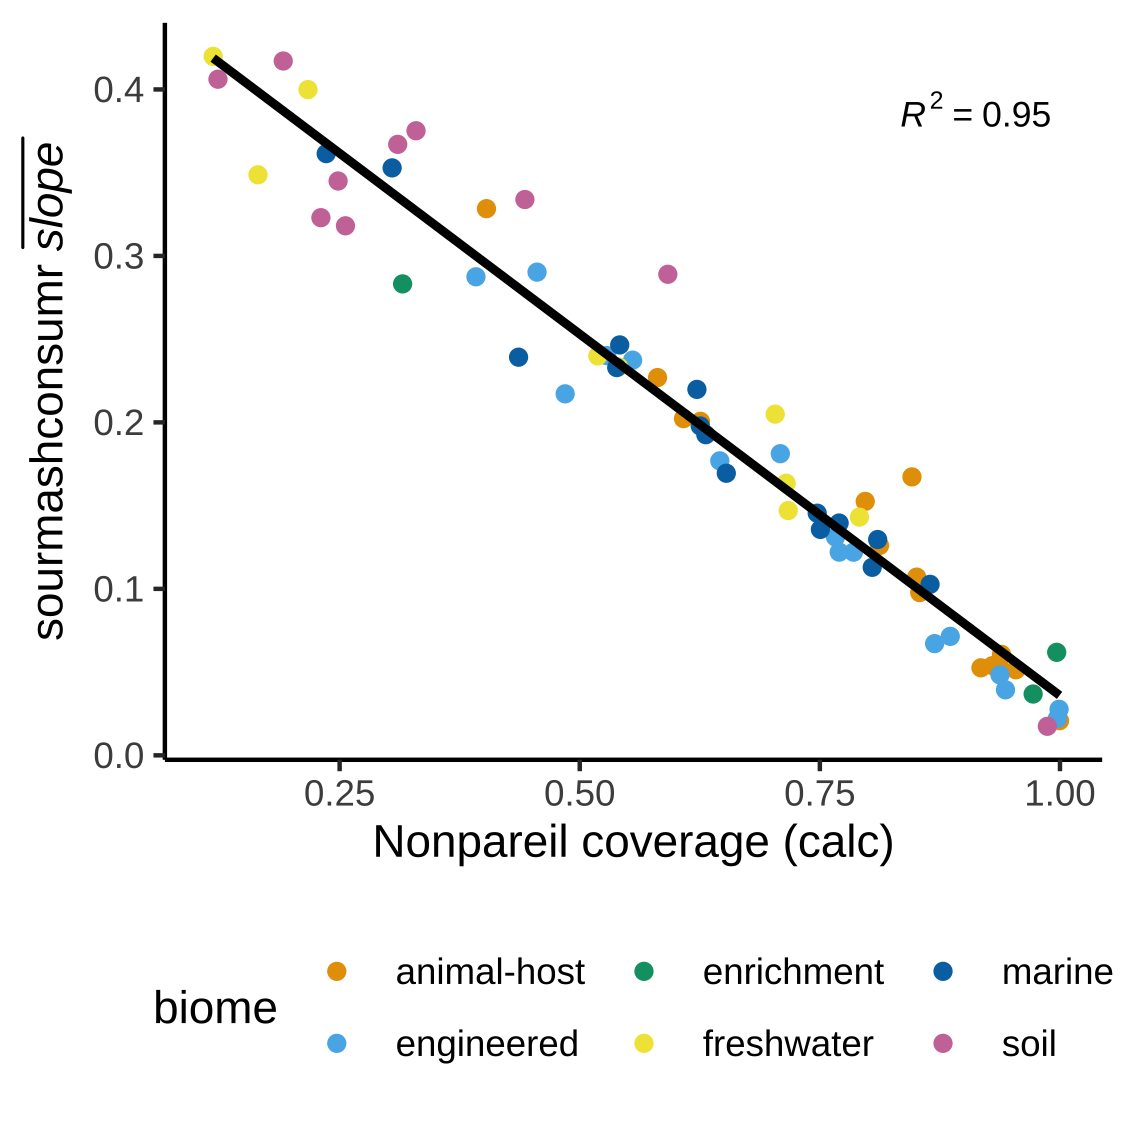

In [25]:
options(repr.plot.width = 3.75, repr.plot.height = 3.75, repr.plot.res = 300)

mean_slope_vs_cov <- ggplot(mSystems_00039_18_fig2, aes(x = C, y = mean_slope)) +
  geom_point(size = 1.5, aes(color = biome)) +
  geom_smooth(method = "lm", se=FALSE, color="black", formula = y ~ x) +
  stat_smooth_func(geom = 'text', method = 'lm', hjust = -4, vjust = 1, parse = T, size = 3) +
  scale_color_manual(values = c("#E69F00", "#56B4E9", "#009E73",
                                "#F0E442", "#0072B2", "#CC79A7"))+
  theme_classic() +
  theme(legend.position = "bottom") +
  labs(x = "Nonpareil coverage (calc)", y = expression(paste("sourmashconsumr ", bar(italic("slope")))))
       
mean_slope_vs_cov 